# AID23063  Lab_Assignment - 2

In [ ]:
!pip install simpleaudio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import simpleaudio as sa
import librosa
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import nltk
from nltk.corpus import cmudict

In [ ]:
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

In [ ]:
audio_file = '/content/LJ001-0014.wav'
y,sr = librosa.load(audio_file);

### Loading Signal data

In [ ]:
y

array([ 0.00909424, -0.00341797, -0.01177979, ..., -0.00131226,
       -0.00131226, -0.00161743], dtype=float32)

In [ ]:
y.size

219293

In [ ]:
sr

22050

### Preprocessing audio

In [ ]:
y_mono = librosa.to_mono(y);
y_mono = librosa.resample(y_mono,orig_sr=sr,target_sr=16000);

In [ ]:
y_mono.size

159125

### Recognizing Text using Wav2Vec2

In [ ]:
cmu_dict = cmudict.dict()

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

input_values = processor(y_mono, return_tensors="pt", sampling_rate=16000).input_values
with torch.no_grad():
    logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)
recognized_text = processor.batch_decode(predicted_ids)[0]



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Convert recognized text to phonemes using NLTK


In [ ]:
def text_to_phonemes(text):
    words = text.lower().split()
    phonemes = [cmu_dict[word][0] if word in cmu_dict else [word] for word in words]
    return " ".join([" ".join(p) for p in phonemes])

phonemes_output = text_to_phonemes(recognized_text)

print("Recognized Text:", recognized_text)
print("Converted Phonemes:", phonemes_output)

Recognized Text: AND IT WAS A MATTER OF COURSE THAT IN THE MIDDLE AGES WHEN THE CRAFTSMEN TOOK CARE THAT BEAUTIFUL FORM SHOULD ALWAYS BE A PART OF THEIR PRODUCTIONS WHATEVER THEY WERE
Converted Phonemes: AH0 N D IH1 T W AA1 Z AH0 M AE1 T ER0 AH1 V K AO1 R S DH AE1 T IH0 N DH AH0 M IH1 D AH0 L EY1 JH AH0 Z W EH1 N DH AH0 K R AE1 F T S M EH0 N T UH1 K K EH1 R DH AE1 T B Y UW1 T AH0 F AH0 L F AO1 R M SH UH1 D AO1 L W EY2 Z B IY1 AH0 P AA1 R T AH1 V DH EH1 R P R AH0 D AH1 K SH AH0 N Z W AH2 T EH1 V ER0 DH EY1 W ER0


### Removing Stress from converted phonemes

In [ ]:
import re

def remove_stress(phoneme_text):
    return re.sub(r'\d', '', phoneme_text)

clean_phonemes = remove_stress(phonemes_output)

print(clean_phonemes)


AH N D IH T W AA Z AH M AE T ER AH V K AO R S DH AE T IH N DH AH M IH D AH L EY JH AH Z W EH N DH AH K R AE F T S M EH N T UH K K EH R DH AE T B Y UW T AH F AH L F AO R M SH UH D AO L W EY Z B IY AH P AA R T AH V DH EH R P R AH D AH K SH AH N Z W AH T EH V ER DH EY W ER


### Extracting phoneme segment for first 3 seconds

In [ ]:
sr=16000
start_sample, end_sample = 0, int(3 * sr)
phoneme_segment = y_mono[start_sample:end_sample]
phoneme_segment

array([ 0.00633552, -0.00672489, -0.01087416, ...,  0.07359752,
       -0.03115339, -0.01792659], dtype=float32)

### Method to match phonemes with time

In [ ]:
def match_phonemes_to_time(phonemes, segment_length, sr):
    num_phonemes = len(phonemes.split())
    phoneme_duration = segment_length / sr / num_phonemes
    phoneme_segments = []
    for i, phoneme in enumerate(phonemes.split()):
        phoneme_segments.append((phoneme, i * phoneme_duration, (i+1) * phoneme_duration))
    return phoneme_segments

### Extracted Phoneme vs Recognized phonemes

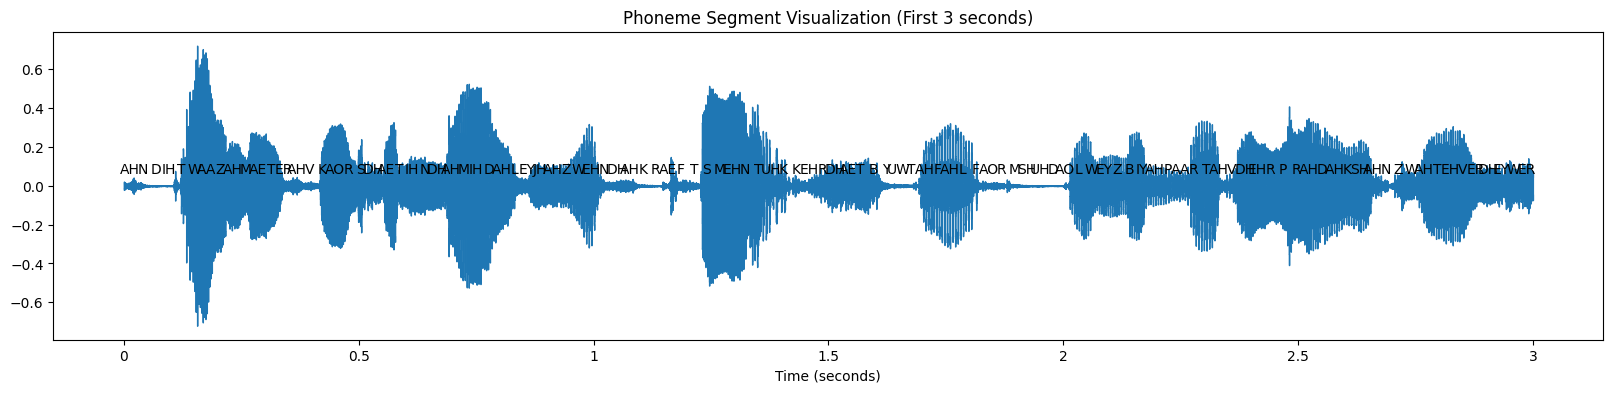

In [ ]:
phoneme_time_segments = match_phonemes_to_time(clean_phonemes, len(phoneme_segment), sr)

plt.figure(figsize=(20, 4))
librosa.display.waveshow(phoneme_segment, sr=sr)
plt.title("Phoneme Segment Visualization (First 3 seconds)")
plt.xlabel("Time (seconds)")

for phoneme, start_time, end_time in phoneme_time_segments:
  plt.text((start_time+end_time)/2,0.05, phoneme, fontsize=10, ha='center', va='bottom')

plt.show()
